# Testing the y-axis alignment of the data

For this exploration, we only need the compressed representation of the connectome, so we load it in "conntility" format.
This package can be installed using:
 > pip install Connectome-Utilities
 
The other packages are standard

In [2]:
import pandas
import numpy
import conntility

fn_mat = "microns_mm3_connectome.h5"
name_dset_f = "full"
name_dset_c = "condensed"

# M = conntility.ConnectivityMatrix.from_h5(fn_mat, name_dset_f)
C = conntility.ConnectivityMatrix.from_h5(fn_mat, name_dset_c)

## Alignment
For many connectome analysis purposes, you might want the coordinate system of the data to be aligned with the anatomy. Specifically, here we want the y-axis to be aligned with the "downward" direction orthogonal to the layer boundaries.

Ideally, this would be done by analyzing the raw EM volume, or anatomically by finding the orientation of apical dendrites in the volume. But here, we do this purely based on connectivity. This is based on the following observation: Locally, i.e. within 150 um, overall connection statistics in cortical circuits are largely symmetrical in the horizontal dimension. Therefore, trans-lamninar local connections, projected into the horizontal plane should have no systematic direction bias. If a bias is observed, it is likely because the projection plane was not perfectly horizontal.

If this was not clear, keep reading below and it will become obvious.

If you vehemently disagree: yes, this is crude. Please read the notes at the end.

Our goal is as follows: 

For all synapses, consider the locations of the pre- and post-synaptic neuron. Calculate the direction of the vector pointing from pre- to the post-synaptic side. Of this data, consider only the trans-laminar connections. For these connections, we know that the vector must have a strong vertical component, but as pointed out above, there should be no systematic horizontal component.

We assemble a dataframe of the direction vectors for all synapses and the pathway they are associated with.

In [3]:
edge_pw = C.edge_associated_vertex_properties("cell_type")
edge_pos_z = C.edge_associated_vertex_properties("z_nm").diff(axis=1).values[:, 1] / 1000 # col - row
edge_pos_y = C.edge_associated_vertex_properties("y_nm").diff(axis=1).values[:, 1] / 1000 # col - row
edge_pos_x = C.edge_associated_vertex_properties("x_nm").diff(axis=1).values[:, 1] / 1000 # col - row
edge_pos = pandas.DataFrame({"dx": edge_pos_x, 
                             "dy": edge_pos_y,
                             "dz": edge_pos_z},
                           index=edge_pw.index)

res_raw = pandas.concat([edge_pw, edge_pos], axis=1)
res_raw

row    col       dx       dy      dz
0        6IT    6CT  -34.112   -9.024   13.64
1        23P  5P_IT  109.440  141.184  252.32
2        23P    23P   15.104 -123.840   34.40
3        23P     4P  -38.592   44.160   34.40
4        23P    23P   19.072  -95.744   49.96
...      ...    ...      ...      ...     ...
6965255  23P    23P  -72.128  101.824   35.32
6965256  23P    23P    2.048   51.456  -34.32
6965257  23P    23P  -43.904   54.464    6.44
6965258  23P    23P   58.496  111.872   32.24
6965259  23P    23P   27.392   32.128  -48.60

[6965260 rows x 5 columns]

Then we calculate the mean vectors for each cell-type specific pathway. This allows us to focus on trans-laminar pathways (the top left corner of the plot below). We calculate for the mean vectors their angle in the x-z plane. 

If the x-z plane is perfectly aligned with the horizontal, then these angles would be all over the place, just stochastic noise.
If it is not perfectly aligned, then there would be a trend where downwards pathways (e.g. L4 to L6) cluster around one angle and upwards pathways around the same angle plus pi.

[Text(0, 0, '23P'),
 Text(0, 1, '4P'),
 Text(0, 2, '5P_IT'),
 Text(0, 3, '5P_NP'),
 Text(0, 4, '5P_PT'),
 Text(0, 5, '6CT'),
 Text(0, 6, '6IT'),
 Text(0, 7, 'BC'),
 Text(0, 8, 'BPC'),
 Text(0, 9, 'MC'),
 Text(0, 10, 'NGC')]

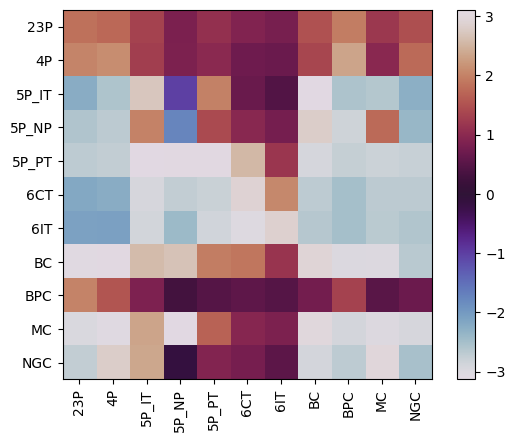

In [4]:
from matplotlib import pyplot as plt

res = res_raw.groupby(["row", "col"])[["dx", "dy", "dz"]].mean()
angle = res.apply(lambda _x: numpy.arctan2(_x["dx"], _x["dz"]), axis=1)
ampl = res.apply(lambda _x: numpy.sqrt(numpy.sum(_x[["dx", "dz"]].values ** 2)), axis=1)

I = angle.unstack("col")
fig = plt.figure()
ax = fig.gca()
plt.colorbar(ax.imshow(I, cmap="twilight"))
ax.set_xticks(range(I.shape[1])); ax.set_xticklabels(I.columns, rotation="vertical")
ax.set_yticks(range(I.shape[0])); ax.set_yticklabels(I.index)

Just by eyeballing, it looks like there is a trend for the trans-laminar pathways.
But it seems noisy, and hence the trend is likely weak. 

We continue by estimating how much unaligned the plane is.

We do this in three steps:
First, we limit the dataframe to only the pathways with clear layer designations.
Then, we evaluate for each pathway whether it goes "upwards" or "downwards" based on the names of the participating cell types.
Finally, we flip the direction of the direction vectors for "upwards" pathways arond by inverting their sign.

Then, the normalized mean direction vector is what the connectome would consider the overall "downward" direction. 

In [7]:
res_nrml = res_raw.set_index(["row", "col"])
lst_e = ["23P", "4P", "5P_IT", "5P_NP", "5P_PT", "6CT", "6IT"]
res_nrml = res_nrml.loc[lst_e].reorder_levels([1, 0]).loc[lst_e]

tmp = res_nrml.index.to_frame().applymap(lambda _x: int(_x[0]))
direction = numpy.sign(numpy.diff(tmp.values, axis=1))[:, 0]

direction = (res_nrml.transpose() * direction).transpose().loc[direction != 0].mean(axis=0)
direction = direction / numpy.sqrt(numpy.sum(direction ** 2))

print(direction)

dx   -0.101190
dy   -0.991151
dz   -0.085905
dtype: float64


We see that it is very strongly, but not perfectly aligned with the y-axis.

We can now add additional, rotated coordinates to the data that should better align the data. 

In [8]:
from scipy.spatial.transform import Rotation

rot, _ = Rotation.align_vectors(numpy.array([[0, -1, 0]]), direction.values.reshape((1, -1)))
locs = C.vertices[["x_nm", "y_nm", "z_nm"]]
locs_tf = rot.apply(locs - locs.mean(axis=0)) + locs.mean(axis=0).values

for col_name, col_vals in zip(["x_nm_aligned", "y_nm_aligned", "z_nm_aligned"],
                             locs_tf.transpose()):
    C.add_vertex_property(col_name, col_vals)


/nvme/reimann/1743111/ipykernel_25387/2990230193.py:3: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = Rotation.align_vectors(numpy.array([[0, -1, 0]]), direction.values.reshape((1, -1)))


#### NOTE:
- I cannot claim that the rotated coordinates have a meaning in the _anatomical_ sense, only in the _connectomics_ sense
- Specifically, they result in a connectome that is less asymmetrical in the x-z plane. This may be desirable for use cases such as fitting a distance-dependent connectivity model.
- Doing this for the entire volume at once may be averaging too much. Maybe it is better to do this separately for smaller subvolumes
- Even better, use a proper flatmap to get the "horizontal" coordinates. A flat map exists for the Allen CCF. So if someone knows how to align this volume with the CCF, please let me know.